In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import math
import random
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import scipy
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse

sns.set(color_codes=True)

import sys
sys.path.append("C:/Tang/influence-release-master")  #设置自定义包的搜索路径
from load_vehicles_bright_testset import load_vehicles_bright_testset
from load_vehicles_dark_testset import load_vehicles_dark_testset
from influence.image_utils import plot_flat_colorimage, plot_flat_colorgrad

Using TensorFlow backend.


In [2]:
num_classes = 2
num_train_ex_per_class = 1000
num_test_ex_per_class = 300

model_name = 'carair_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
image_data_sets_b = load_vehicles_bright_testset(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class)
image_data_sets_d = load_vehicles_dark_testset(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class)

X_train = image_data_sets_b.train.x
X_test_b = image_data_sets_b.test.x
Y_train = image_data_sets_b.train.labels * 2 - 1
Y_test_b = image_data_sets_b.test.labels * 2 - 1
X_test_d = image_data_sets_d.test.x
Y_test_d = image_data_sets_d.test.labels * 2 - 1
del image_data_sets_b
del image_data_sets_d

Loading vehicles from disk...
Loading vehicles from disk...


The test index now is 324. 
Test image:
-1.0 0.9979225993156433 0.9991083741188049
Top from Inception_b:
591 -1.0 4.353664815425873e-05
1907 -1.0 6.57704472541809e-05
1279 -1.0 7.795761525630951e-05
1375 -1.0 8.733707666397094e-05
887 -1.0 0.00014575594663619995
Top from Inception_d:
1519 -1.0 2.0204819738864897e-05
1907 -1.0 2.2817358374595643e-05
1279 -1.0 2.3930275812745093e-05
1375 -1.0 3.2656721770763396e-05
887 -1.0 0.00010924158990383148


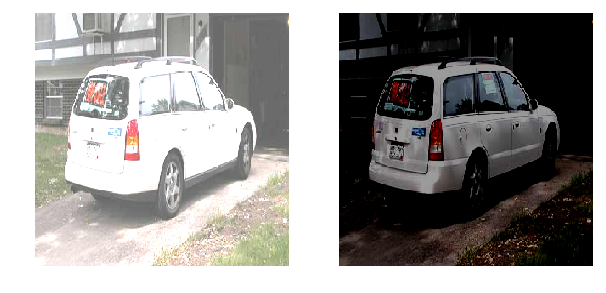

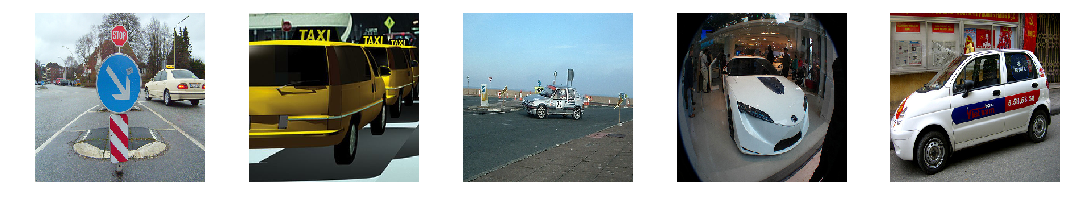

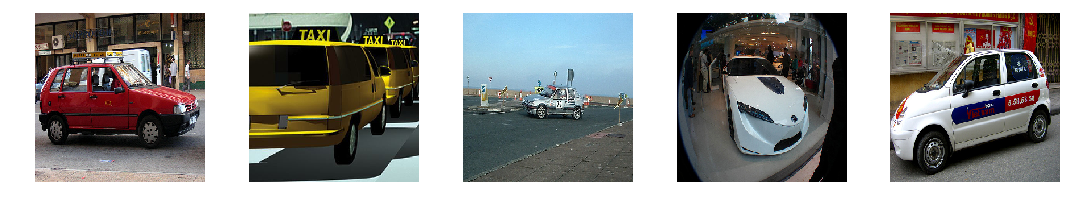

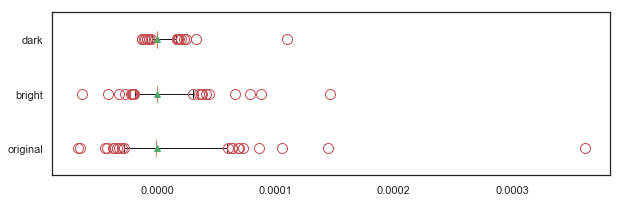

In [12]:
influence_important=[]
# for i in [15, 18, 38, 41, 59, 91, 99, 103, 111, 116, 123, 143, 147, 165, 167, 168, 
#           176, 179, 205, 243, 268, 280, 324, 359, 365, 406, 522, 533, 549, 576, 583]:
for i in [324]:
    f = np.load('output6/rbf_carair_results_%s.npz' % i)
    fb = np.load('output18/adver_testset_carair_results_%s.npz' % i)
    fd = np.load('output19/dark_testset_carair_results_%s.npz' % i)
    test_idx = fb['test_idx']
    inception_Y_pred_correct_b = fb['inception_Y_pred_correct']
    inception_Y_pred_correct_d = fd['inception_Y_pred_correct']
    
#     distances = f['distances']
#     flipped_idx = f['flipped_idx']
#     rbf_margins_test = f['rbf_margins_test']
#     rbf_margins_train = f['rbf_margins_train']        
#     rbf_predicted_loss_diffs = f['rbf_predicted_loss_diffs']
    inception_predicted_loss_diffs_b = fb['inception_predicted_loss_diffs']
    inception_predicted_loss_diffs_d = fd['inception_predicted_loss_diffs']
    
    influence_important.append(f['inception_predicted_loss_diffs'])
    influence_important.append(inception_predicted_loss_diffs_b)
    influence_important.append(inception_predicted_loss_diffs_d)

    print('The test index now is %s. ' % i)
    sns.set_style('white')
    fontsize=14

    print('Test image:')
    print(Y_test_d[test_idx], inception_Y_pred_correct_b[test_idx], inception_Y_pred_correct_d[test_idx])
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].axis('off')
    axs[0].imshow((np.reshape(X_test_b[test_idx, :], [299, 299, 3]) + 1) / 2, interpolation='none')
    axs[1].axis('off')
    axs[1].imshow((np.reshape(X_test_d[test_idx, :], [299, 299, 3]) + 1) / 2, interpolation='none')
#     plt.savefig('finish/brightness_%s.jpg' % i, dpi=300, bbox_inches='tight')

    print('Top from Inception_b:')
    fig, axs = plt.subplots(1, 5, figsize=(15,3))
    for counter, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs_b)[-5:]):
        print(train_idx, Y_train[train_idx], inception_predicted_loss_diffs_b[train_idx])    
        x_train = X_train[train_idx, :]
        axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[counter].axis('off')
    plt.tight_layout()
#     plt.savefig('finish/bright_%s_top_inception.jpg' % i, dpi=300, bbox_inches='tight')
    
    print('Top from Inception_d:')
    fig, axs = plt.subplots(1, 5, figsize=(15,3))
    for counter, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs_d)[-5:]):
        print(train_idx, Y_train[train_idx], inception_predicted_loss_diffs_d[train_idx])    
        x_train = X_train[train_idx, :]
        axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[counter].axis('off')
    plt.tight_layout()
#     plt.savefig('finish/dark_%s_top_inception.jpg' % i, dpi=300, bbox_inches='tight')

    plt.show()

plt.figure(figsize=(10,3))
labels=['original', 'bright', 'dark']
flierprops = dict(marker='o',  markersize=10,
                  linestyle='none', markeredgecolor='r')
plt.boxplot(influence_important,
        labels=labels,
        vert=False,
        whis=[0.5, 99.5],
        #notch=True,
        showmeans=True,
        showbox=False,
        flierprops=flierprops)
plt.savefig('finish/brightness_%s_influence_value.jpg' % i, dpi=300, bbox_inches='tight')

In [7]:
influence_important

2